Daeduck PCB AOI Dataset
=============
분석자: 정회희 (Last update: 2018/05/28)

## Problem definition, evaluation 및 데이터셋 관련 기본 정보

- 데이터셋 저장 경로: //211.106.187.119/Data/018_daeduck/AOI-data-analysis/original
- 산업 도메인: pcb
- 문제 유형: Classification
- 클래스 유형: 2 Classes
    - 정상: 9972
    - 불량: 2762

- 이미지 유형: Single-RGB-image
- 원본 이미지 크기 및 채널 수: 384 X 480 X 3 -> 224 X 224 X 3 으로 resize해서 저장 (참고로 raw dataset에서 IMAGE - 복사본_xx.bmp 파일과 xx.bmp 파일이 있는데, 복사본이라고 해서 xx.bmp와 겹치는 파일이 있지는 않음. 복사본을 제외한 뒤 파일명이 겹치는 경우도 있었지만, numpy array로 만들어서 서로 비교해봤을 때 달랐음.)
- Evaluation
    - Evaluation metric: Error rate
    - Evaluation method: 하나의 원본 이미지를 하나의 제품 인스턴스로 하여 성능 도출
    

In [19]:
import os, sys
sys.path.append('..')
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import json

from sklearn.manifold import TSNE
from skimage.io import imread, imsave

from datasets import dataset as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from models.utils import grad_cam, get_feature_maps

from datasets.utils import view_image_cam_pairs

In [48]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf").get_name()
rc('font', family=font_name)

In [2]:
image_save_dir = './images'

In [3]:
""" Load dataset """
root_dir = ('/Data/018_daeduck/AOI-data-analysis/original') # FIXME

In [4]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
cls_list = anno_dict['classes'].values()
print(cls_list)

dict_values(['불량', '정상'])


In [51]:
# data statistics over classes

filename_list = glob.glob(root_dir+'/image/*')

print('e.g., ', filename_list[0])

print('모든 데이터셋 크기:', len(filename_list))

OK = list(filter(lambda x: '정상' in x, filename_list))
NG = list(filter(lambda x: '불량' in x, filename_list))

print('# of files:', len(filename_list),'/ # of OK:', len(OK),'/ # of NG:', len(NG))


e.g.,  /Data/018_daeduck/AOI-data-analysis/original/image/정상_1155786-0007S_02_gimg_serial0044_0301500_0337280_gray.png
모든 데이터셋 크기: 12734
# of files: 12734 / # of OK: 9972 / # of NG: 2762


In [52]:
# domain 정보 없음!

In [ ]:
# dic = {cls:[] for cls in cls_list}

for file in filename_list:
    filename = file.split('/')[-1]
    cls = filename.split('_')[0]
    dic[cls].append(filename)

y =[]
x = []
for cls in dic.keys():
    print(cls,':',len(dic[cls]))
    x.append(cls); y.append(len(dic[cls]))

plt.bar(range(len(x)),y, tick_label=x)
plt.savefig(os.path.join(image_save_dir,'class_bar.png'))
plt.show()

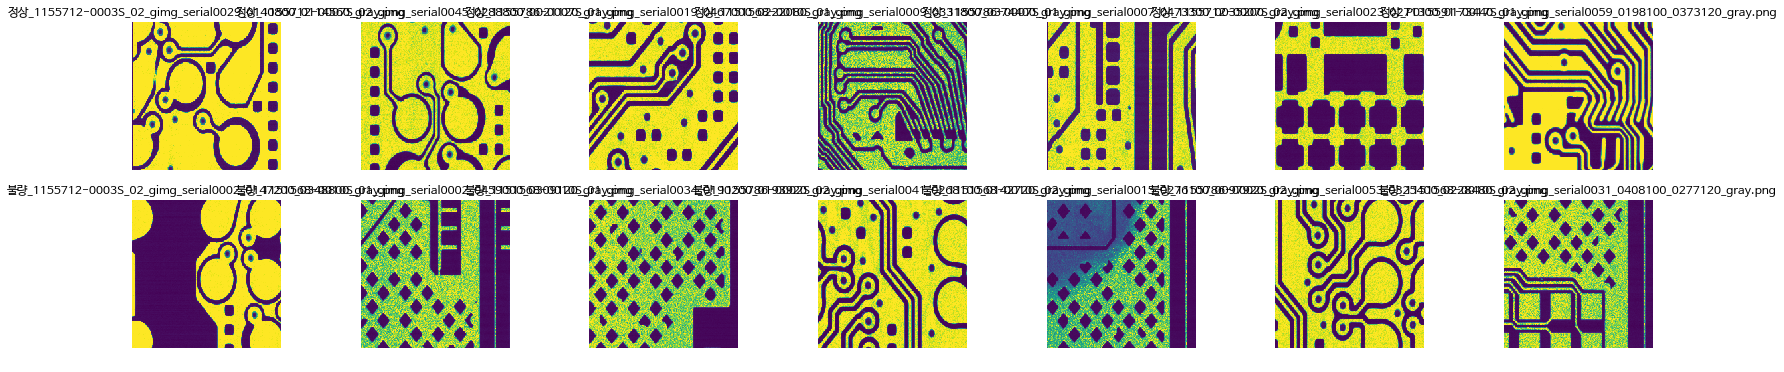

In [49]:
# image samples
n_rows = len(dic.keys())
n_cols = 7
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

for j in range(n_rows):
    c = list(dic.keys())[j]
    samples = np.random.choice(dic[c], size=n_cols, replace=False)
    for i in range(n_cols):
        filename = samples[i]
        file_path = os.path.join(root_dir, 'image', filename)
        image = imread(file_path)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title(filename)

plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')
plt.show()

---

## 초기 학습 및 테스트 방법

### Architecture
- ResNet-18

### Optimization, Regularization

#### Parameter initialization

- He et al.의 normal initialization 방법을 채택함
    - He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.
    
#### Gradient descent optimizer

- SGD + momentum

#### Training hyperparameters

- Batch size: 64
- Number of epochs: 300
- Initial learning rate: 0.10
- Momentum: 0.9
- Learning rate decay schedule: validation 성능이 plateau를 보일 때마다, 기존 learning rate를 decay 
    - learning rate patience = 30
    - validation score threshold: 1e-4
    - learning rate decay: 0.1
        - 위의 각 hyperparameters에 대한 설명의 경우, SuaLab 기술 블로그의 AlexNet 학습 부분 참조
- Batch sampling 방법: uniform sampling
        
#### Regularization

- L2 weight decay: 0.0001
- Data augmentation: LR flip, UD flip (4x augmentation)
    - Training 시에만 LR flip, UD flip, LR+UD flip 각각 25% 확률로 augmentation 수행
    - Test 시에는 augmentation을 수행하지 않음
- Batch normalization
    - 모든 conv layer와 ReLU layer 사이에 batch normalization을 적용

In [21]:
# Load test set
test_list, anno_dict = dataset.read_data_subset(root_dir, mode='test')
test_set = dataset.Dataset(root_dir, test_list, anno_dict)
print(len(test_set), type(test_set))
print(len(test_list))

1274 <class 'datasets.dataset.Dataset'>
1274


In [22]:
""" Set test hyperparameters """
hp_d = dict()
mean = np.array([0.58467299, 0.58467299, 0.58467299], dtype=np.float32)
# fold 5: 5154 secs to train, 0.1791 test error, 
image_mean = np.transpose(np.tile(mean,(224,224,1)),[2,0,1])
hp_d['image_mean'] = image_mean

# Test hyperparameters
hp_d['batch_size'] = 256

In [27]:
""" Load weights and start test """
model = ConvNet([3, 224, 224], len(anno_dict['classes']), **hp_d)
model.logits.restore('/Data/checkpts/model_fold_5_trainval_ratio_1.0.dnn') # FIXME
# model_daeduck_channel3.dnn (channel mean: 0.58467299)
evaluator = Evaluator()
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = model.predict(test_set, **hp_d)

total_time = time.time() - start_time

/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/cntk/core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


conv1.shape (64, 112, 112)
pool1.shape (64, 56, 56)
conv2_2.shape (64, 56, 56)
conv3_2.shape (128, 28, 28)
conv4_2.shape (256, 14, 14)
conv5_2.shape (512, 7, 7)
pool6.shape (512, 1, 1)


In [28]:
# Accuracy
print('Test error rate: {}'.format(test_score))

Test error rate: 0.15240625000000002


In [ ]:
# Tact time 
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))

In [31]:
# Confusion matrix
print('Confusion matrix: \n{}'.format(confusion_matrix))

Confusion matrix: 
[[950  51]
 [143 130]]


In [33]:
# confusion matrix to tex code
def conf_to_tex_table(confusion_matrix):
    temp = ''
    temp += '| |'
    for i in range(len(confusion_matrix[0])):
        temp += 'y^={}|'.format(i)
    temp += '\n'
    temp += '|-----|'
    for i in range(len(confusion_matrix[0])):
        temp += '-----|'.format(i)
    temp += '\n'
    ct = 0
    for row in confusion_matrix:
        temp += '|y={}|'.format(ct)
        for ele in row:
            temp += '{}|'.format(ele)
        temp += '\n'
        ct += 1
    return temp

print(conf_to_tex_table(confusion_matrix))

| |y^=0|y^=1|
|-----|-----|-----|
|y=0|950|51|
|y=1|143|130|



In [34]:
# performance - training set size plot
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Load results from pickle file
with open('../output/cv_daeduck_resnet_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)

In [35]:
test_score_per_train_portion = dict()
for fold_idx in test_result_dict.keys():
    for portion in test_result_dict[fold_idx].keys():
        if portion not in test_score_per_train_portion:
            test_score_per_train_portion[portion] = []
        test_score_per_train_portion[portion].append(test_result_dict[fold_idx][portion])
# test_score_per_train_portion
# >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}

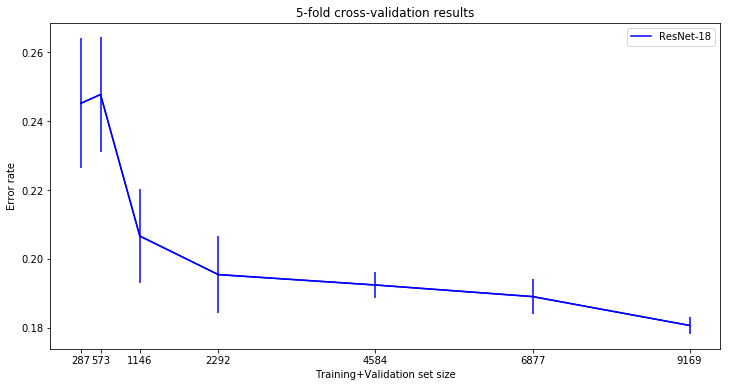

In [37]:
trainval_list, _ = dataset.read_data_subset(root_dir, mode='train1')
total_set_size = len(trainval_list)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = [v*total_set_size for v in sorted(test_score_per_train_portion.keys())]
y_mean = [np.mean(l) for k, l in sorted(test_score_per_train_portion.items())]
y_std = [np.std(l) for k, l in sorted(test_score_per_train_portion.items())]
_ = ax.plot(x, y_mean, color='b', label='ResNet-18')
_ = ax.errorbar(x, y_mean, yerr=y_std, color='b')
_ = ax.set_title('5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Training+Validation set size')
_ = ax.set_xticks(x)
_ = plt.legend()

plt.savefig(os.path.join(image_save_dir, 'cross_validation_results.png'), bbox_inches='tight')
plt.show()
# >> output: accuracy graph averaged over 5 folds

underfitting

Correct ones for class 정상


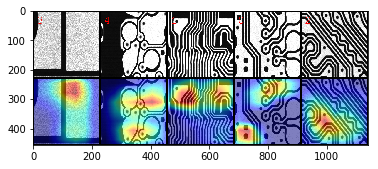

Wrong ones for class 정상


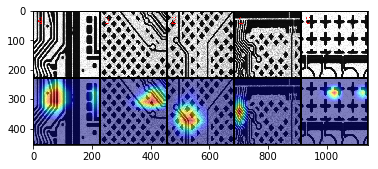

Correct ones for class 불량


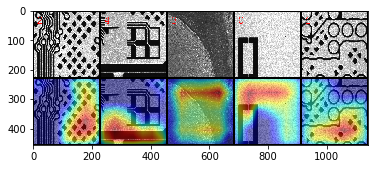

Wrong ones for class 불량


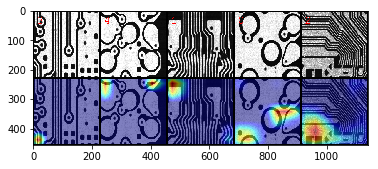

In [38]:
# CAM visualization on the feature layer

num_samples = 5 # FIXME

test_list_cor = []
test_list_wrn = []

for i in range(ys.shape[1]):
    correct = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)==i))
    wrong = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)!=i))
    test_list_cor.append(np.extract(correct, test_list))
    test_list_wrn.append(np.extract(wrong, test_list))
    
#print(len(test_list_cor))
#print(len(test_list_wrn))

test_list_cam = [test_list_cor, test_list_wrn]

for i in range(len(test_list_cor)):
    for j in range(2):
        corwrn = 'Correct' * (1-j) + 'Wrong' * j
        print('{} ones for class {}'.format(corwrn,anno_dict['classes'][str(i)]))
        try:
            filename_list = test_list_cam[j][i][0:num_samples]
            cam, X = grad_cam(model, dataset, root_dir, filename_list, anno_dict, i, 'conv5_2', **hp_d)
            img = view_image_cam_pairs(X, cam, n_samples=num_samples, border=2, n_cols=num_samples)
            imshow(img)
            plt.show()
            imsave(os.path.join(image_save_dir, 'class_{}_{}_grad_cam.jpg'.format(i,corwrn)), img)
        except:
            print('Not enough data for {} ones'.format(corwrn))


In [41]:
# T-SNE visualization on the feature layer

test_feature_maps, images, test_labels = get_feature_maps(model, dataset, root_dir, test_list, anno_dict, 'conv5_2', **hp_d)
print(test_feature_maps.shape)

(1274, 512, 7, 7)


In [42]:
# Flatten feature maps into feature vectors
test_features = test_feature_maps.reshape((test_feature_maps.shape[0], -1))
print(test_features.shape)

(1274, 25088)


In [43]:
import time
tic = time.time()
test_embeddings = TSNE(n_components=2, verbose=1).fit_transform(test_features)
toc = time.time()
print('TSNE takes {} secs'.format(toc-tic))
print(test_embeddings.shape)
np.save('./test_embeddings.npy',test_embeddings)
#test_embeddings = np.load('./test_embeddings.npy')

# if it takes too much time, reduce data into half, or etc.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1274 samples in 0.605s...
[t-SNE] Computed neighbors for 1274 samples in 56.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1274
[t-SNE] Computed conditional probabilities for sample 1274 / 1274
[t-SNE] Mean sigma: 3.546154
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.651825
[t-SNE] Error after 1000 iterations: 1.244191
TSNE takes 71.43806338310242 secs
(1274, 2)


In [44]:
from datasets.utils import view_tsne_embeddings

In [45]:
#images = np.ones((17386,3,28,28)) # (N,C,H,W)
emb_image = view_tsne_embeddings(test_embeddings, images, test_labels)
imsave(os.path.join(image_save_dir, 'convnet_embed.jpg'), emb_image)
# 정상 -> class 0 (검은 테두리)
# 불량 -> class 1 (붉은 테두리)

In [47]:
img_list = list(anno_dict['images'].keys())
print(img_list[0], anno_dict['images'][img_list[0]])

정상_1155712-0007S_02_gimg_serial0020_0315800_0343680_gray.png {'size': {'channel': 1, 'width': 224, 'height': 224}, 'class': [0]}


In [40]:
len(test_list)

1274